In [1]:
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import healpy as hp
import xarray as xr

# CEH crop data

The UK Centre for Ecology and Hydrology Land Cover Plus crop maps (https://www.ceh.ac.uk/services/ceh-land-cover-plus-crops-2015) use remote sensing data from two satellites, Copernicus Sentinel-1 C-band SAR and Sentinel-2 optical imaging, to generate a catalog of land parcels classified by crop types.
Data can be accessed through a free academic licence from Digimap (https://digimap.edina.ac.uk/environment), going to 'Environment Data Download'.

To get the data select an area of interest on the map using the drawing tools and then select the desired dataset for the selected area. Land Cover Plus provides data for the 2016-2020 year range.
After adding the datasets to the basket and checking out, a confirmation email is sent to get access to the files in `.gdb` format.
The naming of the files depends on the ID of the data query, hence we rename them here for clarity.

In this notebook we plot the positions and crop types within the historic county of Yorkshire.
To obtain the Yorkshire county boundaries we use Boundary-Lane data from the Ordnance Survey Data Hub https://osdatahub.os.uk/downloads/open/BoundaryLine, which can be accessed for free by selecting the GeoPackage data format, and extracting the `bdline_gb.gpkg` file.

Then, a CSV file containing positions, area, and crop types is generated and saved for use in the package.

In [2]:
# Resolution in meters
resolution = 2000

# Year 2016 - 
years = np.arange(2016,2022)

border_file = '../../data/land/bdline_gb.gpkg' 
crop_files = [f'../../data/land/CEH/UK_CEH_Crops_{year}.gdb' for year in years]

In [3]:
fiona.listlayers(border_file)

['boundary_line_ceremonial_counties',
 'boundary_line_historic_counties',
 'community_ward',
 'country_region',
 'county',
 'county_electoral_division',
 'district_borough_unitary',
 'district_borough_unitary_ward',
 'english_region',
 'greater_london_const',
 'high_water',
 'historic_european_region',
 'parish',
 'polling_districts_england',
 'scotland_and_wales_const',
 'scotland_and_wales_region',
 'unitary_electoral_division',
 'westminster_const']

In [4]:
# Yorkshire = 66
counties = gpd.read_file(border_file, layer='boundary_line_historic_counties')
polygon = counties['geometry'].iloc[66]
counties

,Name,Area_Description,geometry
0,Berkshire,Historic County,"MULTIPOLYGON (((422004.502 199086.601, 422030...."
1,Buckinghamshire,Historic County,"MULTIPOLYGON (((460619.899 235588.003, 460625...."
2,Hertfordshire,Historic County,"MULTIPOLYGON (((499772.602 215220.503, 499795...."
3,Herefordshire,Historic County,"MULTIPOLYGON (((335069.501 272770.499, 335082...."
4,Oxfordshire,Historic County,"MULTIPOLYGON (((424473.304 224921.896, 424502...."
...,...,...,...
90,Warwickshire,Historic County,"MULTIPOLYGON (((456472.501 274014.303, 456299...."
91,Dorset,Historic County,"MULTIPOLYGON (((333203.198 91375.703, 333185.9..."
92,Devon,Historic County,"MULTIPOLYGON (((333223.945 91353.145, 333218.0..."
93,Banffshire,Historic County,"MULTIPOLYGON (((349516.703 868874.397, 349519...."


In [5]:
xmin, ymin, xmax, ymax = polygon.bounds
print(xmin, ymin, xmax, ymax)
size = np.ceil([(xmax - xmin)/resolution, (ymax - ymin)/resolution]).astype(int)

binsx = np.linspace(xmin, xmax, size[0]+1)
binsy = np.linspace(ymin, ymax, size[1]+1)

print(size)

357386.0036 378555.099 542313.704 529856.1995
[93 76]


In [6]:
crop0 = gpd.read_file(crop_files[5], mask = polygon)

crop_codes = np.unique(crop0['crop_code'])
code_dict = dict(zip(crop_codes, np.arange(len(crop_codes))))
print(code_dict)

{'be': 0, 'fb': 1, 'gr': 2, 'ma': 3, 'or': 4, 'ot': 5, 'pe': 6, 'po': 7, 'sb': 8, 'sl': 9, 'so': 10, 'sw': 11, 'wb': 12, 'wo': 13, 'ww': 14}


In [7]:
areas = np.zeros((len(years), len(crop_codes), size[1], size[0]))

for iyear in range(len(years)):
    print(years[iyear])
    
    crops = gpd.read_file(crop_files[iyear], mask = polygon)

    crops_simple = crops.drop(columns = ['poly_id', 'parent', 'gid'])
    crops_simple['geometry'] = crops_simple.centroid
    crops_simple['area'] = crops.area

    posx = crops_simple['geometry'].x.to_numpy()
    posy = crops_simple['geometry'].y.to_numpy()

    ix = np.digitize(posx, binsx)
    ix[ix==size[0]] = size[0]-1
    iy = np.digitize(posy, binsy)
    iy[iy==size[1]] = size[1]-1
    
    ctype = crops_simple['crop_code']
    itype = np.zeros(len(crops_simple), dtype=int)

    for it, t in enumerate(ctype):
        itype[it] = code_dict[t]

    areas[iyear, itype, iy, ix] += crops_simple['area']
areas[areas==0]=np.nan

2016
2017
2018
2019
2020
2021


In [8]:
xcoords = 0.5 * (binsx[1:] + binsx[:-1])
ycoords = 0.5 * (binsy[1:] + binsy[:-1])

# data = xr.DataArray(areas, dims=("Year", "Type", "y", "x"), coords={"Year":years, "Type":crop_codes, "x":xcoords, "y":ycoords})
data = xr.Dataset(
    data_vars = dict(
        area=(["Year", "Type", "y", "x"], areas)
    ),
    coords = dict(
        x=("x", xcoords),
        y=("y", ycoords),
        Year=("Year", years),
        Type=("Type", crop_codes),        
    )
)

In [9]:
data

<xarray.Dataset>
Dimensions:  (Year: 6, Type: 15, y: 76, x: 93)
Coordinates:
  * x        (x) float64 3.584e+05 3.604e+05 3.624e+05 ... 5.393e+05 5.413e+05
  * y        (y) float64 3.796e+05 3.815e+05 3.835e+05 ... 5.269e+05 5.289e+05
  * Year     (Year) int64 2016 2017 2018 2019 2020 2021
  * Type     (Type) object 'be' 'fb' 'gr' 'ma' 'or' ... 'so' 'sw' 'wb' 'wo' 'ww'
Data variables:
    area     (Year, Type, y, x) float64 nan nan nan nan nan ... nan nan nan nan

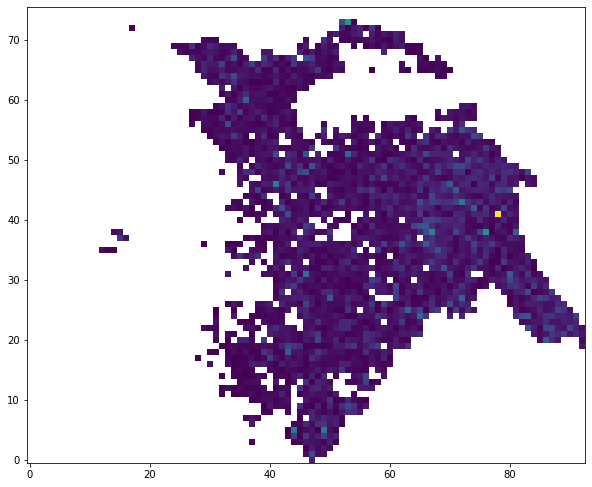

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(data.area.sel(Year=2016, Type='ww'), interpolation='none', origin='lower')

In [11]:
encoding = {"area":{"dtype":"float32", "zlib": True, "complevel": 5}}
data.to_netcdf(f"../../agrifoodpy/land/data/CEH_{resolution}.nc", encoding=encoding)

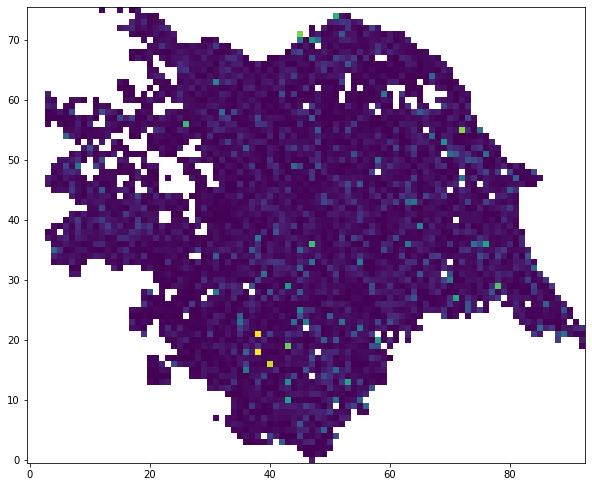

In [12]:
data_read = xr.open_dataset(f"../../agrifoodpy/land/data/CEH/CEH_{resolution}.nc")
plt.figure(figsize=(10,10))
plt.imshow(data_read.area.sel(Year=2020, Type='gr'), interpolation='none', origin='lower')

In [13]:
data.Year.values

array([2016, 2017, 2018, 2019, 2020, 2021])